# compare RMSD of different periods and sites

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## 6 month intervals

In [3]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')
df = wave.read('FLX_JP-BBY', method='file')

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

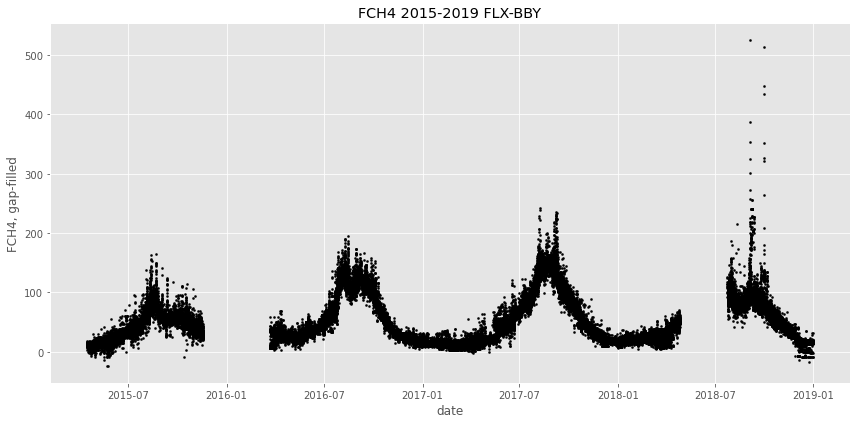

In [5]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="FCH4 2015-2019 FLX-BBY")

In [6]:
date_ranges = [pd.date_range(start, stop, freq='30min') for [start, stop] in [['2015-01', '2015-07'], 
                                                                        ['2015-07', '2016-01'], 
                                                                        ['2016-01', '2016-07'], 
                                                                        ['2016-07', '2017-01'], 
                                                                        ['2017-01', '2017-07'], 
                                                                        ['2017-07', '2018-01'], 
                                                                        ['2018-01', '2018-07'], 
                                                                        ['2018-07', '2018-12-30']]]

In [7]:
idates = [df.loc[date_range, 'FCH4_F'].notna().index for date_range in date_ranges] #convert date ranges to indices, ignoring missing data

In [8]:
for idate in idates:
    dfw = df.loc[idate, :]
    dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
    
#     dfp = wave.wave(dfw) # process to new df
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
#            title='{} - {}'.format(idate[0], idate[-1]), 
#              filename = 'plot/20210714_iwata7_{}_{}.jpeg'.format(idate[0].year, idate[0].month))
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df


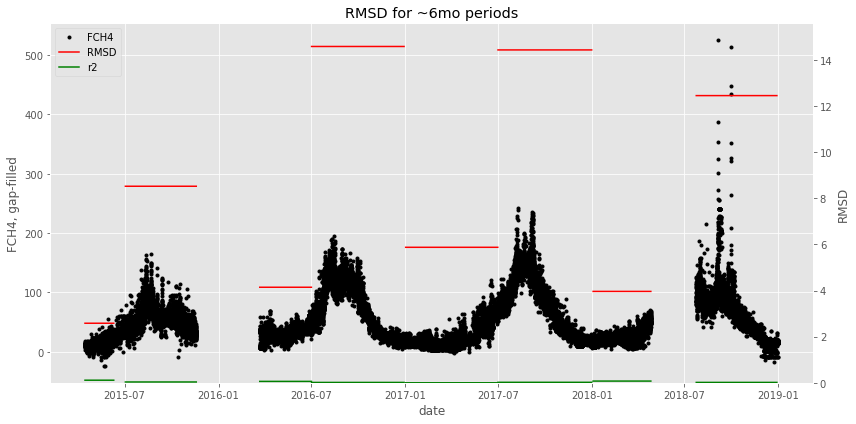

In [9]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(df.index, df.loc[:, 'FCH4_F'], 'k.', label='FCH4')
ax.set(xlabel = 'date', ylabel = 'FCH4, gap-filled', title = 'RMSD for ~6mo periods')

axr = ax.twinx()
axr.grid(False)
axr.yaxis.set_label_position('right')
axr.yaxis.tick_right()
axr.plot(df.index, df.loc[:, 'rmsd'], 'r-', label='RMSD')
axr.plot(df.index, df.loc[:, 'r2'], 'g-', label='r2')
axr.set_ylim([0, df.loc[:, 'rmsd'].max() + 1])
axr.set_ylabel('RMSD')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
linesr, labelsr = axr.get_legend_handles_labels()
ax.legend(lines + linesr, labels + labelsr, loc=2)

plt.tight_layout()
# plt.savefig('plot/20210709_rmsd_vs_date.jpeg')

## 2 month intervals

In [3]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')
df = wave.read('FLX_JP-BBY', method='file')

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

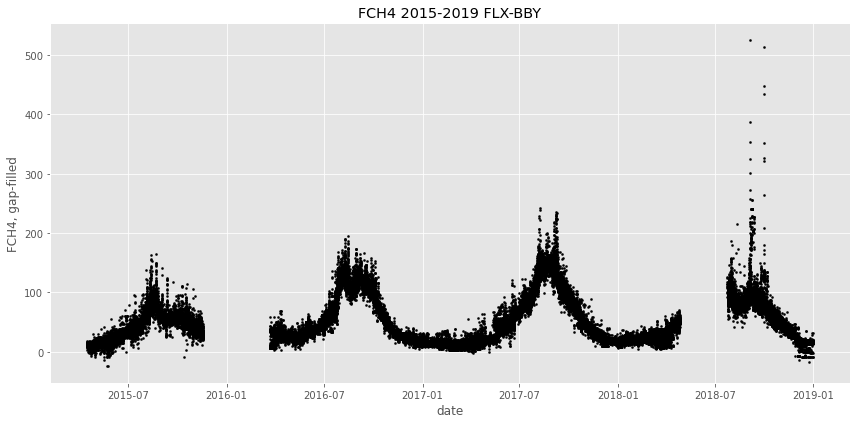

In [5]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="FCH4 2015-2019 FLX-BBY")

In [ ]:
windows = wave.chop(df)

In [7]:
start = df['FCH4_F'].first_valid_index()
windows = []

while start < df.index[-1]:
    start = df.loc[start:, 'FCH4_F'].first_valid_index()
    window = pd.date_range(start, periods = 1920, freq = '30min')
    
    if window[-1] < df.index[-1]:
        if df.loc[window, 'FCH4_F'].isna().any():
            print('window {} to {} contains missing data'.format(window[0], window[-1]))
        else:
            print('appending window {} to {} to windows'.format(window[0], window[-1]))    
            windows.append(window)
    
    start = window[-1]

appending window 2015-04-14 11:30:00 to 2015-05-24 11:00:00 to windows
appending window 2015-05-24 11:00:00 to 2015-07-03 10:30:00 to windows
appending window 2015-07-03 10:30:00 to 2015-08-12 10:00:00 to windows
appending window 2015-08-12 10:00:00 to 2015-09-21 09:30:00 to windows
appending window 2015-09-21 09:30:00 to 2015-10-31 09:00:00 to windows
window 2015-10-31 09:00:00 to 2015-12-10 08:30:00 contains missing data
appending window 2016-03-21 17:00:00 to 2016-04-30 16:30:00 to windows
appending window 2016-04-30 16:30:00 to 2016-06-09 16:00:00 to windows
appending window 2016-06-09 16:00:00 to 2016-07-19 15:30:00 to windows
appending window 2016-07-19 15:30:00 to 2016-08-28 15:00:00 to windows
appending window 2016-08-28 15:00:00 to 2016-10-07 14:30:00 to windows
appending window 2016-10-07 14:30:00 to 2016-11-16 14:00:00 to windows
appending window 2016-11-16 14:00:00 to 2016-12-26 13:30:00 to windows
appending window 2016-12-26 13:30:00 to 2017-02-04 13:00:00 to windows
appen

In [13]:
[w[0] for w in windows]

[Timestamp('2015-04-14 11:30:00', freq='30T'),
 Timestamp('2015-05-24 11:00:00', freq='30T'),
 Timestamp('2015-07-03 10:30:00', freq='30T'),
 Timestamp('2015-08-12 10:00:00', freq='30T'),
 Timestamp('2015-09-21 09:30:00', freq='30T'),
 Timestamp('2016-03-21 17:00:00', freq='30T'),
 Timestamp('2016-04-30 16:30:00', freq='30T'),
 Timestamp('2016-06-09 16:00:00', freq='30T'),
 Timestamp('2016-07-19 15:30:00', freq='30T'),
 Timestamp('2016-08-28 15:00:00', freq='30T'),
 Timestamp('2016-10-07 14:30:00', freq='30T'),
 Timestamp('2016-11-16 14:00:00', freq='30T'),
 Timestamp('2016-12-26 13:30:00', freq='30T'),
 Timestamp('2017-02-04 13:00:00', freq='30T'),
 Timestamp('2017-03-16 12:30:00', freq='30T'),
 Timestamp('2017-04-25 12:00:00', freq='30T'),
 Timestamp('2017-06-04 11:30:00', freq='30T'),
 Timestamp('2017-07-14 11:00:00', freq='30T'),
 Timestamp('2017-08-23 10:30:00', freq='30T'),
 Timestamp('2017-10-02 10:00:00', freq='30T'),
 Timestamp('2017-11-11 09:30:00', freq='30T'),
 Timestamp('2

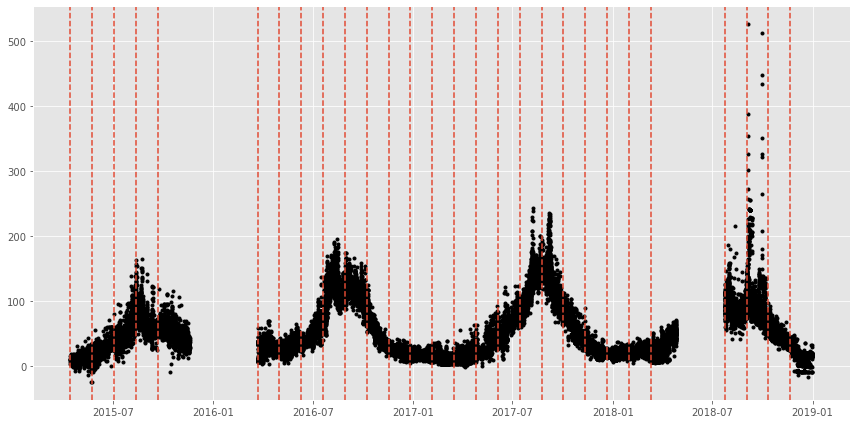

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df.loc[df.index, 'FCH4_F'], 'k.')
for w in windows:
    ax.axvline(w[0], ls='--')

fig.tight_layout()

In [9]:
for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
#            title='{} - {}'.format(idate[0], idate[-1]), 
#              filename = 'plot/20210714_iwata7_{}_{}.jpeg'.format(idate[0].year, idate[0].month))
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df

In [11]:
if df.loc[window, 'FCH4_F'].isna().any():
    print('period contains missing data')
else:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
#            title='{} - {}'.format(idate[0], idate[-1]), 
#              filename = 'plot/20210714_iwata7_{}_{}.jpeg'.format(idate[0].year, idate[0].month))
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df

In [14]:
df.loc[dfw.index, 'rmsd']

2015-05-24 11:00:00    3.056168
2015-05-24 11:30:00    3.056168
2015-05-24 12:00:00    3.056168
2015-05-24 12:30:00    3.056168
2015-05-24 13:00:00    3.056168
                         ...   
2015-07-03 08:30:00    3.056168
2015-07-03 09:00:00    3.056168
2015-07-03 09:30:00    3.056168
2015-07-03 10:00:00    3.056168
2015-07-03 10:30:00    3.056168
Freq: 30T, Name: rmsd, Length: 1920, dtype: float64

In [27]:
windows = [pd.date_range(months[i], months[i+1], freq='30min') for i in range(len(months)-1)]

if windows[-1][-1] == df.index[-1]:
    print('time series end matches frequency, not appending last period')
else:
    windows.append(pd.date_range(months[-1], df.index[-1], freq='30min'))

len(windows[-1])

Timestamp('2015-04-14 11:30:00')

In [27]:
months = pd.date_range(start, df.index[-1], freq = '2MS')
windows = [pd.date_range(months[i], months[i+1], freq='30min') for i in range(len(months)-1)]

if windows[-1][-1] == df.index[-1]:
    print('time series end matches frequency, not appending last period')
else:
    windows.append(pd.date_range(months[-1], df.index[-1], freq='30min'))

len(windows[-1])

Timestamp('2015-04-14 11:30:00')

In [14]:
idates = [df.loc[date_range, 'FCH4_F'].notna().index for date_range in date_ranges] #convert date ranges to indices, ignoring missing data 

In [23]:
df.loc[df.loc[idates[0], 'FCH4_F'].notna().index[0], 'FCH4_F']

nan

In [25]:
for idate in idates:
    dfw = df.loc[idate, :]
    dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
    
#     dfp = wave.wave(dfw) # process to new df
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
#            title='{} - {}'.format(idate[0], idate[-1]), 
#              filename = 'plot/20210714_iwata7_{}_{}.jpeg'.format(idate[0].year, idate[0].month))
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df


LinAlgError: SVD did not converge in Linear Least Squares

KeyError: 'rmsd'

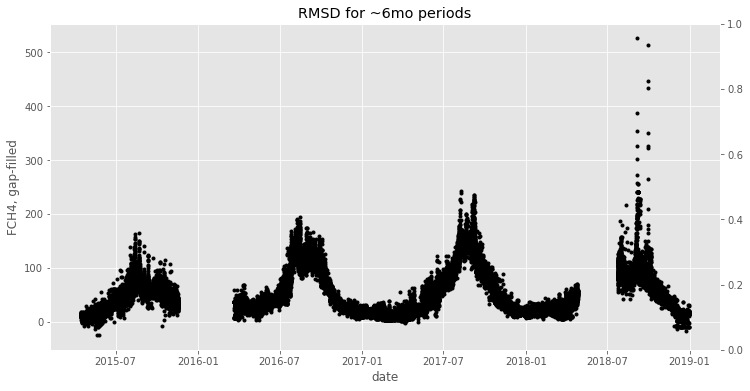

In [17]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(df.index, df.loc[:, 'FCH4_F'], 'k.', label='FCH4')
ax.set(xlabel = 'date', ylabel = 'FCH4, gap-filled', title = 'RMSD for ~6mo periods')

axr = ax.twinx()
axr.grid(False)
axr.yaxis.set_label_position('right')
axr.yaxis.tick_right()
axr.plot(df.index, df.loc[:, 'rmsd'], 'r-', label='RMSD')
axr.plot(df.index, df.loc[:, 'r2'], 'g-', label='r2')
axr.set_ylim([0, df.loc[:, 'rmsd'].max() + 1])
axr.set_ylabel('RMSD')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
linesr, labelsr = axr.get_legend_handles_labels()
ax.legend(lines + linesr, labels + labelsr, loc=2)

plt.tight_layout()
# plt.savefig('plot/20210709_rmsd_vs_date.jpeg')